In [1]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd
from PIL import Image
import shutil
from patchify import patchify, unpatchify
import re
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\neilr\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


**Defining the function to crop the images**

In [36]:
def crop_image(im):
   
    # finding the threshold to isolate the region of interest
    _, output = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), 50, 60, cv2.THRESH_BINARY)
    # getting rid of noise
    output = cv2.medianBlur(output, 15)
    kernel = np.ones((9, 9), dtype="uint8")
    output = cv2.erode(output, kernel, iterations=2)
    output = cv2.dilate(output, kernel, iterations=2)

    # finding components
    _, _, stats, _ = cv2.connectedComponentsWithStats(output)

    # filtering the statistics to get the right object
    # limitations on x: discard the background and other artifacts
    # limitations on width/height: make sure the object is big enough
    df = pd.DataFrame(stats, columns=['x', 'y', 'width', 'height', 'area']).sort_values('area', ascending=False)
    df = df[df['x'] > 0]
    df = df[df['x'] < 4000]
    df = df[df['height'] > 1000]
    df = df[df['width'] > 1000]

    # get the statistics for the filtered object
    x, y, width, height, _ = np.array(df.head(1))[0]

    # crop the image
    im_cropped = im[y:y + max(width, height), x:x + max(width, height)]

    dims= {"x": x, "y": y, "size": max(width, height)} 

    return im_cropped, dims

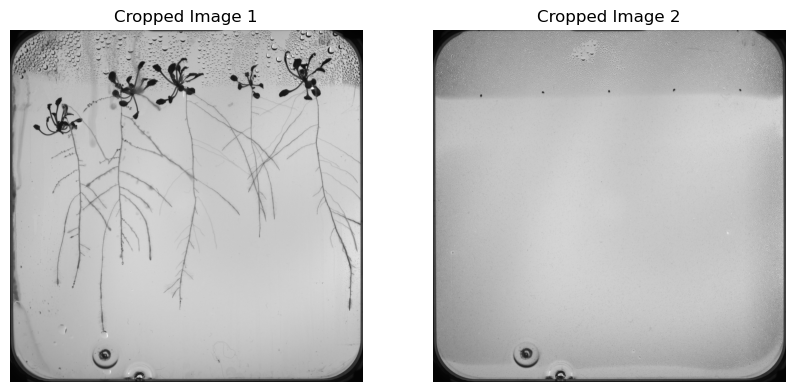

In [41]:
def process_images(folder, save_folder):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            im_cropped, _ = crop_image(img)
            save_path = os.path.join(save_folder, filename)
            cv2.imwrite(save_path, im_cropped)

# Paths to the folders containing images
train_images = "./dataset_raw/Images raw/train raw"
test_images = "./dataset_raw/Images raw/test raw"
val_images = "./dataset_raw/Images raw/val raw"

# Paths to the folders where cropped images will be saved
cropped_train_images_folder = "./dataset/Images/train/"
cropped_test_images_folder = "./dataset/Images/test/"
cropped_val_images_folder = "./dataset/Images/val/"


# Process and save images from both folders
process_images(train_images, cropped_train_images_folder)
process_images(test_images, cropped_test_images_folder)
process_images(val_images, cropped_val_images_folder)

# Load a couple of cropped images for visualization
cropped_images = []
for folder in [cropped_train_images_folder, cropped_test_images_folder, cropped_val_images_folder]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            cropped_images.append(img)
        if len(cropped_images) == 2:
            break
    if len(cropped_images) == 2:
        break

# Visualize the first two cropped images
plt.figure(figsize=(10, 5))
for i, img in enumerate(cropped_images):
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Cropped Image {i+1}")
    plt.axis('off')
plt.show()

**Getting the dimensions to crop the masks from the ccropped images of task 2**

In [38]:
im = cv2.imread("./dataset_raw/Images raw/test raw/030_43-2-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish Eye Corrected.png")


In [39]:
cropped_im, dims2 = crop_image(im)

In [40]:
x, y, size = dims2["x"], dims2["y"], dims2["size"]

**Croppin the masks and storing them in the directory**

In [35]:
def crop_tif_directory(input_directory, output_directory, x, y, size):
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_directory, exist_ok=True)

        # List all files in the input directory
        files = os.listdir(input_directory)
        print(files)
        for file in files:
            if file.endswith(".tif"):
                input_file = os.path.join(input_directory, file)
                output_file = os.path.join(output_directory, f"{os.path.splitext(file)[0]}.tif")
                print(f"input_file: {input_file}")
                print(f"output_file: {output_file}")

                img = cv2.imread(input_file)
                print("one")
                cropped_img = img[y:y+size,x:x+size]
                #cropped_img = img.crop((x, y, x + size, y + size))  # Adjust the crop dimensions
                print("two")
                cv2.imwrite(output_file,cropped_img)
                print(f"Image cropped successfully: {file}")

        print(f"All images cropped and saved as .png files to {output_directory}")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_dir = "./dataset_raw/Masks raw/"
output_dir = './dataset/Masks/'

# Assuming x, y, and size are already defined correctly
crop_tif_directory(input_dir, output_dir, x, y, size)

['001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_occluded_root_mask.tif', '001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_root_mask.tif', '001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_seed_mask.tif', '001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_shoot_mask.tif', '001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_occluded_root_mask.tif', '001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_root_mask.tif', '001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_seed_mask.tif', '001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_shoot_mask.tif', '002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected_occluded_root_mask.tif', '002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected_root_mask.tif', '002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected_seed_mask.tif', '002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corr

In [3]:
def padder(image, patch_size):
 
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
 
    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding
 
    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
 
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
 
    return padded_image

In [4]:
def get_mask_type(file_name):
    # Check for 'occluded_root' first due to its similarity with 'root'
    if '_occluded_root_mask.tif' in file_name:
        return 'occluded_root'

    # List of other mask types
    mask_types = ['root', 'shoot', 'seed']

    # Iterate through each of the remaining mask types
    for mask in mask_types:
        if f'_{mask}_mask.tif' in file_name:
            return mask

    # If no mask type is found, print a message and return None
    print("Can't find mask type for: ", file_name)
    return None

In [5]:
scaling_factor = 1
patch_size = 256
dataset_types = [ 'test','train', 'val']  # Loop through all dataset types

for dataset_type in dataset_types:
    for image_path in glob.glob(f"./dataset/Images/{dataset_type}/*.png"):
        base_name = os.path.basename(image_path)
        img_name, _ = os.path.splitext(base_name)

        # Omit image if its mask doesn't exist yet
        if not os.path.exists(f"./dataset/Masks/{img_name}_root_mask.tif"):
            continue

        # Patchify image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = padder(img, patch_size)

        if scaling_factor != 1:
            img = cv2.resize(img, (0,0), fx=scaling_factor, fy=scaling_factor)

        img_patches = patchify(img, (patch_size, patch_size), step=patch_size)
        img_patches = img_patches.reshape(-1, patch_size, patch_size, 1)

        # Ensure directory exists for image patches
        image_patches_dir = f"./dataset_patched/Images/{dataset_type}/{dataset_type}"
        os.makedirs(image_patches_dir, exist_ok=True)

        for i, patch in enumerate(img_patches):
            image_patch_path = f"{image_patches_dir}/{img_name}_{i}.png"
            if not os.path.exists(image_patch_path):  # Check if file already exists
                cv2.imwrite(image_patch_path, patch)

        # Patchify all 4 masks of the image
        for mask_path in glob.glob(f"./dataset/Masks/{img_name}*.tif"):
            mask_base_name = os.path.basename(mask_path)
            mask_name, _ = os.path.splitext(mask_base_name)
            mask_type = get_mask_type(mask_base_name)

            if mask_type is None:
                print(f"Can't find mask type for: {mask_base_name}")
                continue

            mask = cv2.imread(mask_path, 0)
            mask = padder(mask, patch_size)

            if scaling_factor != 1:
                mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)

            mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            for i, patch in enumerate(mask_patches):
                mask_patches_all_dir = f"./dataset_patched/Masks/All/{dataset_type}/{dataset_type}"
                mask_patches_type_dir = f"./dataset_patched/Masks/{mask_type}/{dataset_type}/{dataset_type}"

                # Ensure directories exist for mask patches
                os.makedirs(mask_patches_all_dir, exist_ok=True)
                os.makedirs(mask_patches_type_dir, exist_ok=True)

                mask_patch_all_path = f"{mask_patches_all_dir}/{mask_name}_{i}.png"
                mask_patch_type_path = f'{mask_patches_type_dir}/{mask_name.replace(mask_type, "")}_{i}.png' if mask_type else f'{mask_patches_type_dir}/{mask_name}_{i}.png'
                
                if not os.path.exists(mask_patch_all_path):
                    cv2.imwrite(mask_patch_all_path, patch)
                if not os.path.exists(mask_patch_type_path):
                    cv2.imwrite(mask_patch_type_path, patch)

In [6]:
from collections import defaultdict
import os
import glob

dataset_types = ['test', 'train', 'val']
count_images = defaultdict(int)
count_masks = defaultdict(int)

for dataset_type in dataset_types:
    image_paths = glob.glob(f"./dataset_patched/Images/{dataset_type}/*.png")
    mask_paths = glob.glob(f"./dataset_patched/Masks/All/{dataset_type}/{dataset_type}/*.tif")

    count_images[dataset_type] = len(image_paths)
    count_masks[dataset_type] = len(mask_paths)

print("Number of Images:")
for dataset_type, count in count_images.items():
    print(f"{dataset_type.capitalize()}: {count}")

print("\nNumber of Masks:")
for dataset_type, count in count_masks.items():
    print(f"{dataset_type.capitalize()}: {count}")


Number of Images:
Test: 0
Train: 0
Val: 0

Number of Masks:
Test: 13068
Train: 34722
Val: 7744


In [7]:
def create_data_generators(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'root/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images


# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256  # Assuming patch_size is predefined

# Create generators for each dataset category
train_gen, train_num_images = create_data_generators('train', img_patches_path, mask_patches_path, patch_size)
test_gen, test_num_images = create_data_generators('test', img_patches_path, mask_patches_path, patch_size)
val_gen, val_num_images = create_data_generators('val', img_patches_path, mask_patches_path, patch_size)

# Print the number of images in each category
print(f"Train images: {train_num_images}")
print(f"Test images: {test_num_images}")
print(f"Val images: {val_num_images}")

Found 8712 images belonging to 1 classes.
Found 8712 images belonging to 1 classes.
8712
Found 4014 images belonging to 1 classes.
Found 4014 images belonging to 1 classes.
4014
Found 1936 images belonging to 1 classes.
Found 1936 images belonging to 1 classes.
1936
Train images: 8712
Test images: 4014
Val images: 1936


In [8]:
def f1_score(y_true, y_pred):
    def true_positive(y_true, y_pred):
        true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        return true_positive

    def calc_recall(y_true, y_pred):
        TP = true_positive(y_true, y_pred)
        all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return TP / (all_positives + K.epsilon())
    
    def calc_precision(y_true, y_pred):
        TP = true_positive(y_true, y_pred)
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return TP / (predicted_positives + K.epsilon())
    
    precision = calc_precision(y_true, y_pred)
    recall = calc_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def intersection_over_union(y_true, y_pred):
    def intersection_union(y_true, y_pred):
        intersect = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        total = K.sum(K.square(y_true), [1, 2, 3]) + K.sum(K.square(y_pred), [1, 2, 3])
        union = total - intersect
        return (intersect + K.epsilon()) / (union + K.epsilon())
    
    return K.mean(intersection_union(y_true, y_pred), axis=-1)

In [9]:
def plot_metrics(history):
    '''
    A function that extracts metrics and plots them per epoch

    Inputs:
        history: history object returned by keras.Model.fit method
    
    Outputs:
        None: the function displays the training metrics by itself
    '''

    # creating the figure for visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    # looping through the metrics
    metrics_to_plot = ['loss', 'accuracy', 'f1_score', 'intersection_over_union']

    for i, metric in enumerate(metrics_to_plot):
        # getting the metric values for training
        train_values = history.history[metric]
        # getting the metric values for validation
        val_metric = 'val_' + metric
        val_values = history.history[val_metric]

        # plotting the metric against epochs for training
        axes[i].plot(range(1, len(train_values) + 1), train_values, label='Training')
        # plotting the metric against epochs for validation
        axes[i].plot(range(1, len(val_values) + 1), val_values, label='Validation')

        # setting the title and labels
        axes[i].set_title(f'{metric.capitalize()} vs Epoch')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()

    plt.tight_layout()
    plt.show()

---
**Model that predicts all the classes**

In [10]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score, intersection_over_union])
    model.summary()
    
    return model

In [11]:
model = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True,
                   mode='min')




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [12]:
# Training configuration
batch_size = 16
epochs = 10

# Calculate steps per epoch for training and validation
train_steps_per_epoch = train_num_images // batch_size
val_steps_per_epoch = val_num_images // batch_size

# Start training the model
history_all = model.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    callbacks=[cb],
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10


544/544 [==============================] - 672s 1s/step - loss: 0.0353 - accuracy: 0.9929 - f1_score: 0.2165 - intersection_over_union: 0.0448 - val_loss: 0.0263 - val_accuracy: 0.9918 - val_f1_score: 0.5674 - val_intersection_over_union: 0.1161
Epoch 2/10
544/544 [==============================] - 688s 1s/step - loss: 0.0142 - accuracy: 0.9954 - f1_score: 0.6295 - intersection_over_union: 0.1264 - val_loss: 0.0168 - val_accuracy: 0.9934 - val_f1_score: 0.6966 - val_intersection_over_union: 0.1577
Epoch 3/10
544/544 [==============================] - 683s 1s/step - loss: 0.0102 - accuracy: 0.9963 - f1_score: 0.7202 - intersection_over_union: 0.1452 - val_loss: 0.0156 - val_accuracy: 0.9941 - val_f1_score: 0.7108 - val_intersection_over_union: 0.1560
Epoch 4/10
544/544 [==============================] - 691s 1s/step - loss: 0.0090 - accuracy: 0.9966 - f1_score: 0.7435 - intersection_over_union: 0.1526 - val_loss: 0.0141 - val_accuracy: 0.9943 - val_f1_score: 0.7279 - val_in

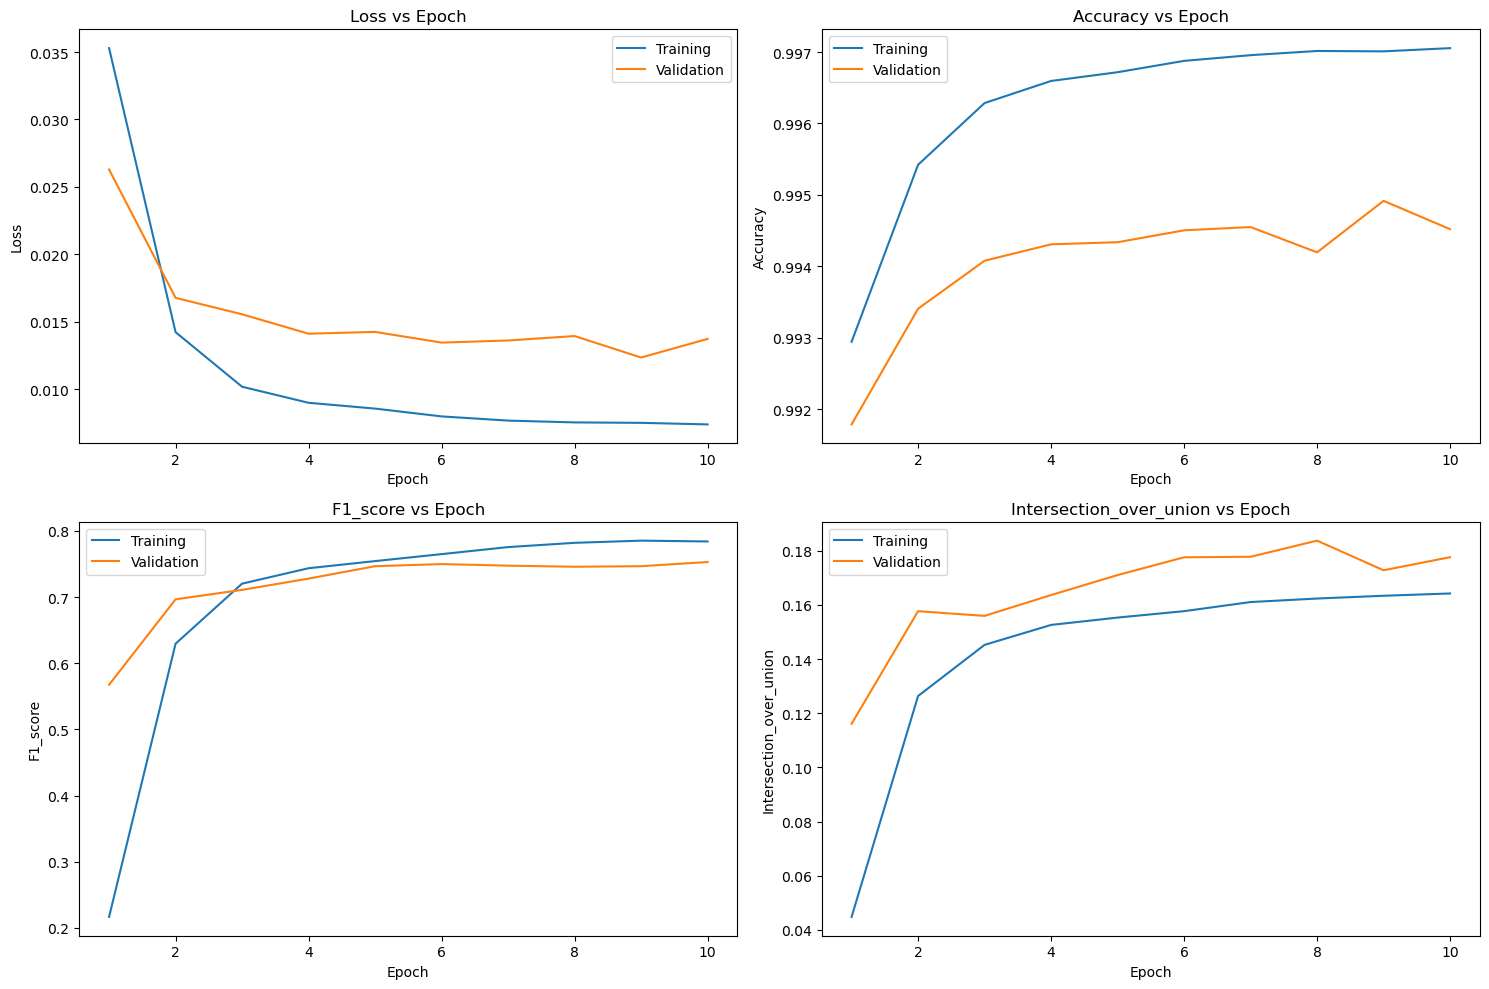

In [13]:
plot_metrics(history_all)

In [11]:
# Predict masks for test data
predicted_masks = model.predict(val_gen, steps=test_num_images // batch_size)

250/250 [==============================] - 44s 176ms/step


In [12]:
predicted_masks.shape

(4000, 256, 256, 1)

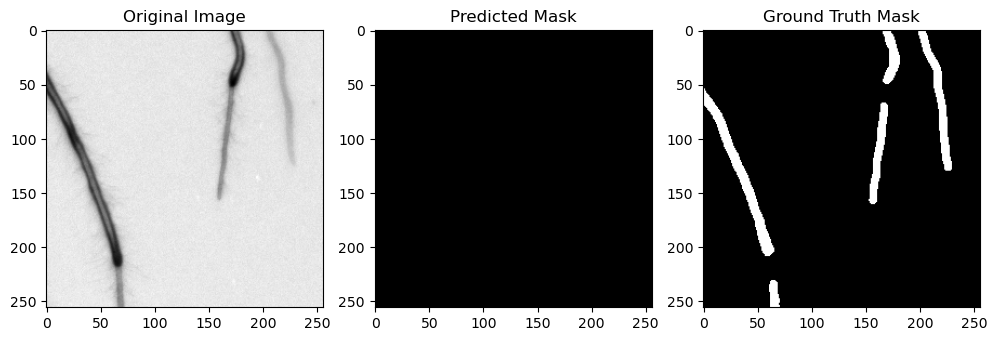

In [13]:
# Assuming 'val_gen' contains test images and masks
num_images_to_load = 16  
loaded_images = []
loaded_masks = []

for _ in range(num_images_to_load):
    batch = next(val_gen)
    loaded_images.extend(batch[0])  
    loaded_masks.extend(batch[1])   

# Selecting the specific image and mask for visualization
selected_image = loaded_images[i]
selected_mask = loaded_masks[i]

# Assuming predicted_masks.shape = (num_images, height, width, channels)
prediction = np.argmax(predicted_masks[i], axis=-1)  

# Visualize the selected image, predicted mask, and ground truth mask (if available)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
ax[0].imshow(selected_image.squeeze(), cmap='gray')  

# Display the predicted mask
ax[1].imshow(prediction.squeeze(), cmap='gray')  

# Display the ground truth mask if available
ax[2].imshow(selected_mask.squeeze(), cmap='gray')  

# Set titles
ax[0].set_title('Original Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()


In [14]:
# Save the trained model
model.save('./model_2.h5')

c:\Users\neilr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save model architecture as JSON
model_json = model.to_json()
with open('./model_2_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights('./model_2_weights.h5')

---
**Model that predicts roots**

In [9]:
def create_data_generators_for_root(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'root/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images

In [10]:
# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256  # Assuming patch_size is predefined

# Create generators for each dataset category
train_gen, train_num_images = create_data_generators_for_root('train', img_patches_path, mask_patches_path, patch_size)
test_gen, test_num_images = create_data_generators_for_root('test', img_patches_path, mask_patches_path, patch_size)
val_gen, val_num_images = create_data_generators_for_root('val', img_patches_path, mask_patches_path, patch_size)

# Print the number of images in each category
print(f"Train images: {train_num_images}")
print(f"Test images: {test_num_images}")
print(f"Val images: {val_num_images}")

Found 8712 images belonging to 1 classes.
Found 8712 images belonging to 1 classes.
8712
Found 4014 images belonging to 1 classes.
Found 4014 images belonging to 1 classes.
4014
Found 1936 images belonging to 1 classes.
Found 1936 images belonging to 1 classes.
1936
Train images: 8712
Test images: 4014
Val images: 1936


In [11]:
model_root = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True,
                   mode='min')




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [12]:
# Training configuration
batch_size = 16
epochs = 10

# Calculate steps per epoch for training and validation
train_steps_per_epoch = train_num_images // batch_size
val_steps_per_epoch = val_num_images // batch_size

# Start training the model
history_root = model_root.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    callbacks=[cb],
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10


544/544 [==============================] - 738s 1s/step - loss: 0.0432 - accuracy: 0.9923 - f1_score: 0.0238 - intersection_over_union: 0.0131 - val_loss: 0.0340 - val_accuracy: 0.9902 - val_f1_score: 0.4278 - val_intersection_over_union: 0.0926
Epoch 2/10
544/544 [==============================] - 738s 1s/step - loss: 0.0264 - accuracy: 0.9937 - f1_score: 0.3283 - intersection_over_union: 0.0716 - val_loss: 0.0231 - val_accuracy: 0.9923 - val_f1_score: 0.5398 - val_intersection_over_union: 0.1156
Epoch 3/10
544/544 [==============================] - 724s 1s/step - loss: 0.0124 - accuracy: 0.9958 - f1_score: 0.6761 - intersection_over_union: 0.1351 - val_loss: 0.0177 - val_accuracy: 0.9938 - val_f1_score: 0.6751 - val_intersection_over_union: 0.1468
Epoch 4/10
544/544 [==============================] - 769s 1s/step - loss: 0.0096 - accuracy: 0.9965 - f1_score: 0.7306 - intersection_over_union: 0.1497 - val_loss: 0.0141 - val_accuracy: 0.9944 - val_f1_score: 0.7411 - val_in

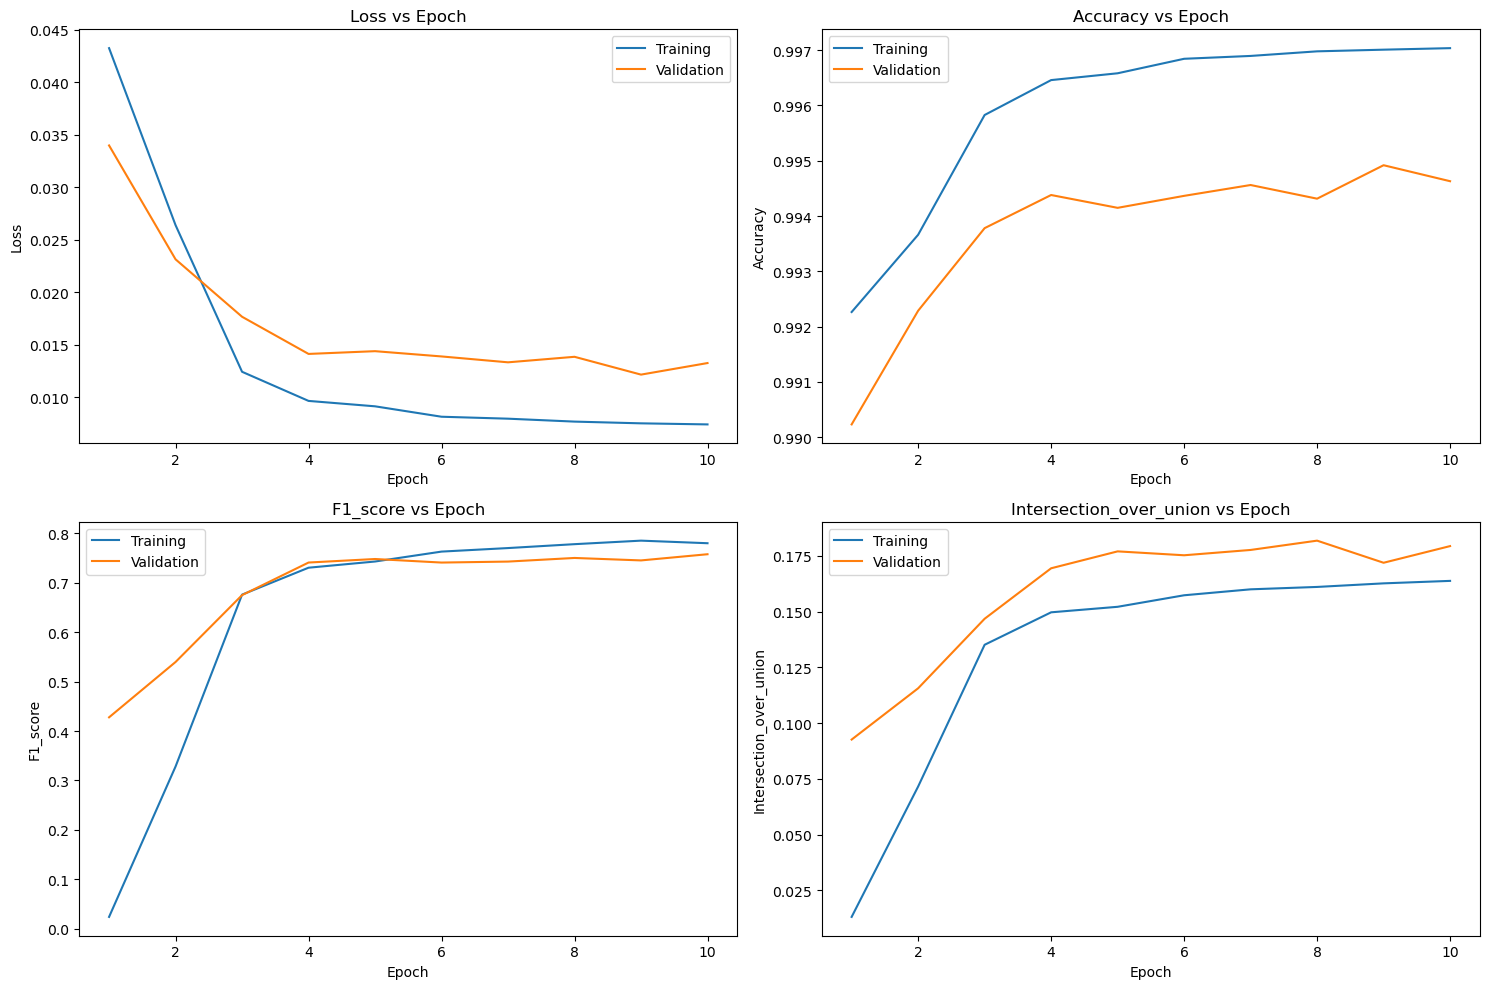

In [15]:
# Plot the training metrics
plot_metrics(history_root)

In [16]:
# Predict masks for test data
predicted_root_masks = model_root.predict(val_gen, steps=test_num_images // batch_size)

250/250 [==============================] - 60s 241ms/step


1/1 [==============================] - 0s 30ms/step


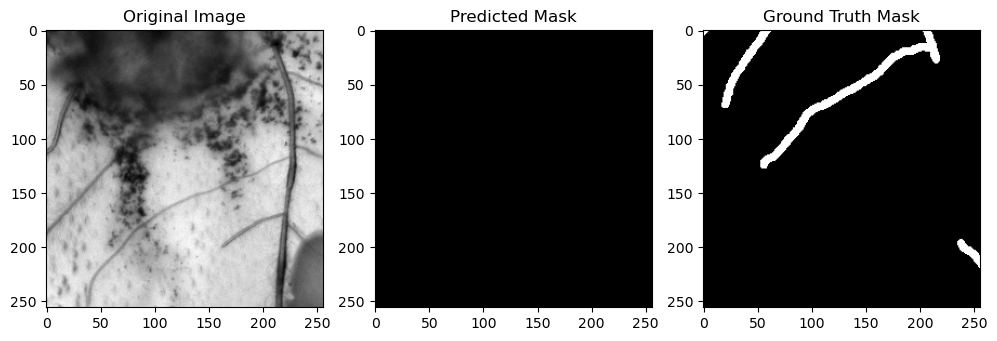

In [56]:
# Assuming 'val_gen' contains test images and masks
num_images_to_load = 20  
loaded_images = []
loaded_masks = []

for _ in range(num_images_to_load):
    batch = next(val_gen)
    loaded_images.extend(batch[0])  
    loaded_masks.extend(batch[1])   

# Selecting the specific image and mask for visualization
selected_image_index = 0  # Choose the index of the image you want to visualize
selected_image = loaded_images[selected_image_index]
selected_mask = loaded_masks[selected_image_index]

# Assuming predicted_masks.shape = (num_images, height, width, channels)
predicted_masks = model_root.predict(np.expand_dims(selected_image, axis=0))
prediction = np.argmax(predicted_masks[0], axis=-1)  

# Visualize the selected image, predicted mask, and ground truth mask (if available)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
ax[0].imshow(selected_image.squeeze(), cmap='gray')  

# Display the predicted mask
ax[1].imshow(prediction.squeeze(), cmap='gray')  

# Display the ground truth mask if available
ax[2].imshow(selected_mask.squeeze(), cmap='gray')  

# Set titles
ax[0].set_title('Original Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [28]:
# Save the trained model
model_root.save('./model_root.h5')

c:\Users\neilr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# Save model architecture as JSON
model_json = model_root.to_json()
with open('./model_root_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model_root.save_weights('./model_root_weights.h5')

---
**Model that predicts shoots**

In [20]:
def create_data_generators_for_shoot(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'shoot/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images

In [21]:
# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256  # Assuming patch_size is predefined

# Create generators for each dataset category
train_gen, train_num_images = create_data_generators_for_shoot('train', img_patches_path, mask_patches_path, patch_size)
test_gen, test_num_images = create_data_generators_for_shoot('test', img_patches_path, mask_patches_path, patch_size)
val_gen, val_num_images = create_data_generators_for_shoot('val', img_patches_path, mask_patches_path, patch_size)

# Print the number of images in each category
print(f"Train images: {train_num_images}")
print(f"Test images: {test_num_images}")
print(f"Val images: {val_num_images}")

Found 8712 images belonging to 1 classes.
Found 8712 images belonging to 1 classes.
8712
Found 4014 images belonging to 1 classes.
Found 3267 images belonging to 1 classes.
4014
Found 1936 images belonging to 1 classes.
Found 1936 images belonging to 1 classes.
1936
Train images: 8712
Test images: 4014
Val images: 1936


In [22]:
model_shoot = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True,
                   mode='min')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         160       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

In [23]:
# Training configuration
batch_size = 16
epochs = 10

# Calculate steps per epoch for training and validation
train_steps_per_epoch = train_num_images // batch_size
val_steps_per_epoch = val_num_images // batch_size

# Start training the model
history_shoot = model_shoot.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    callbacks=[cb],
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
544/544 [==============================] - 727s 1s/step - loss: 0.0242 - accuracy: 0.9932 - f1_score: 0.0522 - intersection_over_union: 0.0169 - val_loss: 0.0146 - val_accuracy: 0.9949 - val_f1_score: 0.4745 - val_intersection_over_union: 0.0493
Epoch 2/10
544/544 [==============================] - 694s 1s/step - loss: 0.0123 - accuracy: 0.9957 - f1_score: 0.4144 - intersection_over_union: 0.0415 - val_loss: 0.0269 - val_accuracy: 0.9946 - val_f1_score: 0.4452 - val_intersection_over_union: 0.0458
Epoch 3/10
544/544 [==============================] - 758s 1s/step - loss: 0.0105 - accuracy: 0.9959 - f1_score: 0.3871 - intersection_over_union: 0.0417 - val_loss: 0.0102 - val_accuracy: 0.9962 - val_f1_score: 0.4950 - val_intersection_over_union: 0.0565
Epoch 4/10
544/544 [==============================] - 689s 1s/step - loss: 0.0079 - accuracy: 0.9969 - f1_score: 0.4623 - intersection_over_union: 0.0476 - val_loss: 0.0105 - val_accuracy: 0.9963 - val_f1_score: 0.5377 - val_inte

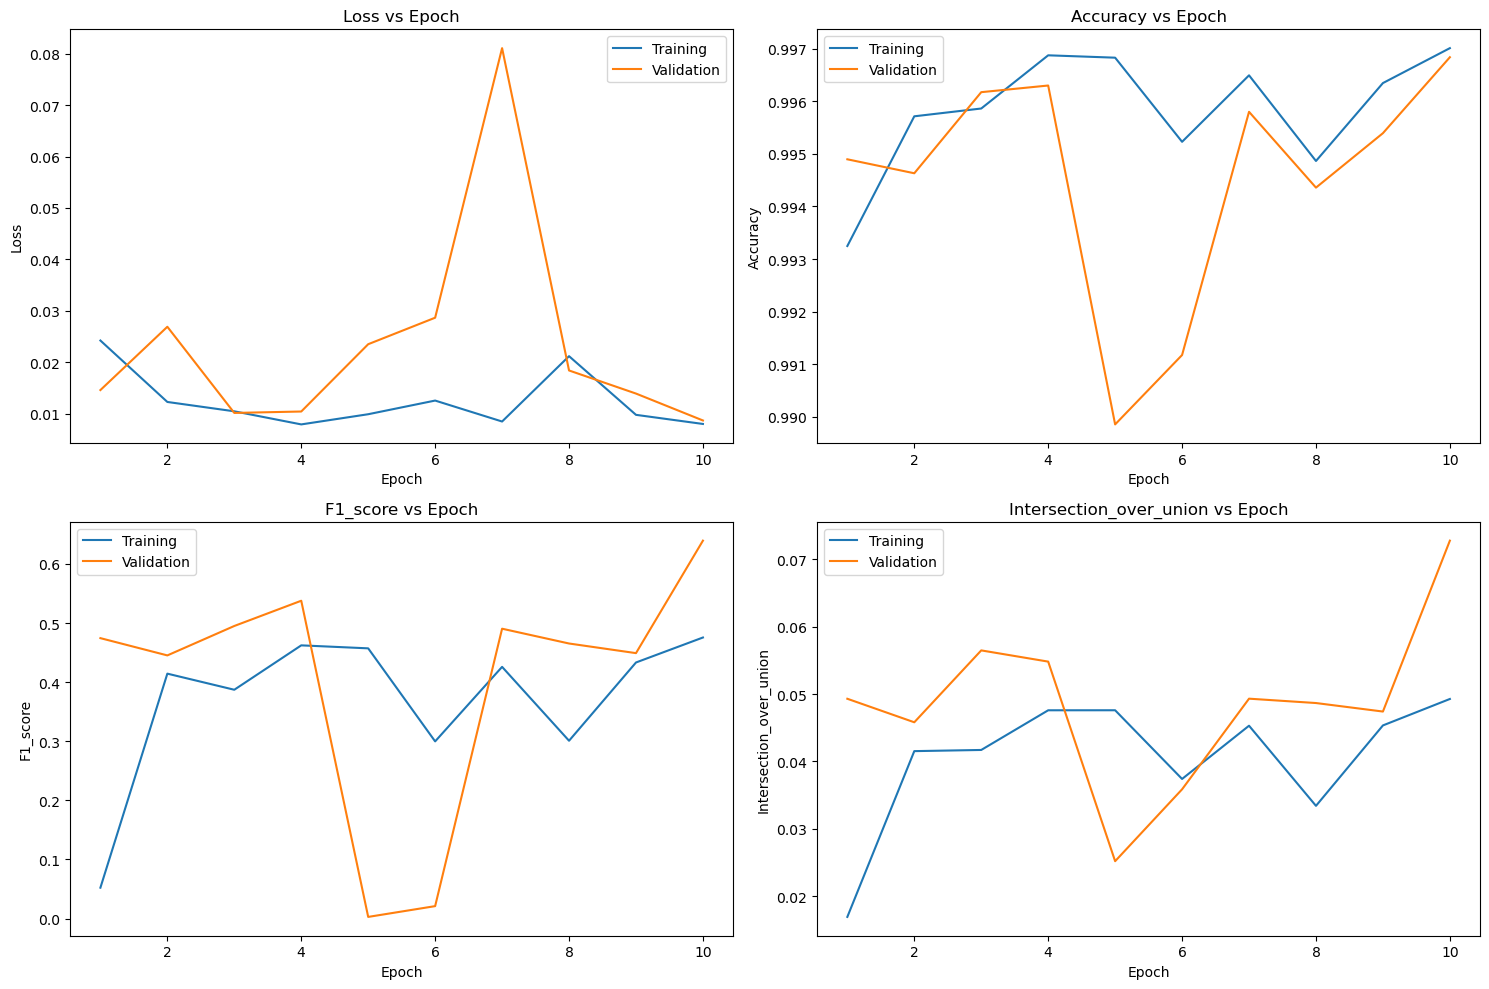

In [24]:
# Plot the training metrics
plot_metrics(history_shoot)

In [24]:
# Predict masks for test data
predicted_root_masks = model_shoot.predict(val_gen, steps=test_num_images // batch_size)

250/250 [==============================] - 65s 260ms/step


In [57]:
from keras.models import load_model
# Load the saved model by providing custom metrics as custom_objects
model_shoot = load_model('./model_shoot.h5', custom_objects={'f1_score': f1_score, 'intersection_over_union': intersection_over_union})

1/1 [==============================] - 0s 31ms/step


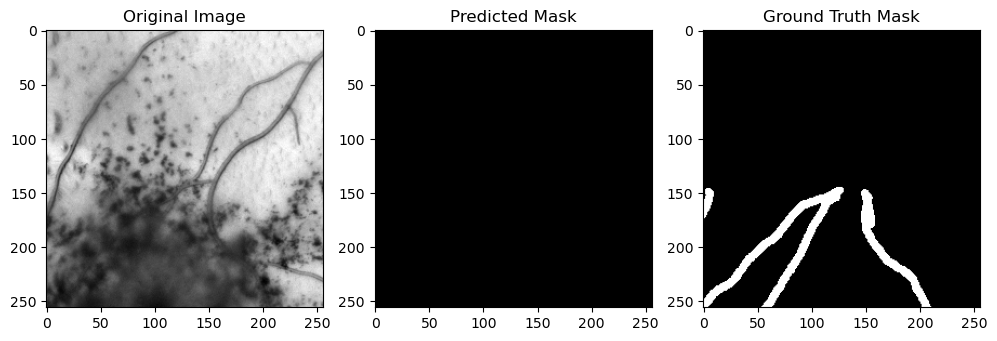

In [115]:
# Assuming 'val_gen' contains test images and masks
num_images_to_load = 16  
loaded_images = []
loaded_masks = []

for _ in range(num_images_to_load):
    batch = next(val_gen)
    loaded_images.extend(batch[0])  
    loaded_masks.extend(batch[1])   

# Selecting the specific image and mask for visualization
selected_image_index = 0  # Choose the index of the image you want to visualize
selected_image = loaded_images[selected_image_index]
selected_mask = loaded_masks[selected_image_index]

# Assuming predicted_masks.shape = (num_images, height, width, channels)
predicted_masks = model_shoot.predict(np.expand_dims(selected_image, axis=0))
prediction = np.argmax(predicted_masks[0], axis=-1)  

# Visualize the selected image, predicted mask, and ground truth mask (if available)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
ax[0].imshow(selected_image.squeeze(), cmap='gray')  
# Display the predicted mask
ax[1].imshow(prediction.squeeze(), cmap='gray')  
# Display the ground truth mask if available
ax[2].imshow(selected_mask.squeeze(), cmap='gray')  

# Set titles
ax[0].set_title('Original Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [26]:
# Save the trained model
model_shoot.save('./model_shoot.h5')

In [27]:
# Save model architecture as JSON
model_json = model_shoot.to_json()
with open('./model_shoot_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model_shoot.save_weights('./model_shoot_weights.h5')

---
**Model that predicts seeds**

In [25]:
def create_data_generators_for_seed(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'seed/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images

In [26]:
# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256  # Assuming patch_size is predefined

# Create generators for each dataset category
train_gen, train_num_images = create_data_generators_for_seed('train', img_patches_path, mask_patches_path, patch_size)
test_gen, test_num_images = create_data_generators_for_seed('test', img_patches_path, mask_patches_path, patch_size)
val_gen, val_num_images = create_data_generators_for_seed('val', img_patches_path, mask_patches_path, patch_size)

# Print the number of images in each category
print(f"Train images: {train_num_images}")
print(f"Test images: {test_num_images}")
print(f"Val images: {val_num_images}")

Found 8712 images belonging to 1 classes.
Found 8712 images belonging to 1 classes.
8712
Found 4014 images belonging to 1 classes.
Found 3267 images belonging to 1 classes.
4014
Found 1936 images belonging to 1 classes.
Found 1936 images belonging to 1 classes.
1936
Train images: 8712
Test images: 4014
Val images: 1936


In [27]:
model_seed = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True,
                   mode='min')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 16)         160       ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_27[0][0]']          
                                                                                            

In [28]:
# Training configuration
batch_size = 16
epochs = 10

# Calculate steps per epoch for training and validation
train_steps_per_epoch = train_num_images // batch_size
val_steps_per_epoch = val_num_images // batch_size

# Start training the model
history_seed = model_seed.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    callbacks=[cb],
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
544/544 [==============================] - 690s 1s/step - loss: 0.0028 - accuracy: 0.9996 - f1_score: 1.5395e-07 - intersection_over_union: 1.8244e-04 - val_loss: 7.0186e-04 - val_accuracy: 0.9999 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 6.3595e-04
Epoch 2/10
544/544 [==============================] - 725s 1s/step - loss: 7.1256e-04 - accuracy: 0.9999 - f1_score: 0.0000e+00 - intersection_over_union: 4.5211e-04 - val_loss: 9.9408e-04 - val_accuracy: 0.9999 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 9.2212e-04
Epoch 3/10
544/544 [==============================] - 722s 1s/step - loss: 6.4870e-04 - accuracy: 0.9999 - f1_score: 0.0000e+00 - intersection_over_union: 8.9602e-04 - val_loss: 9.1992e-04 - val_accuracy: 0.9999 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 3.9317e-04
Epoch 4/10
544/544 [==============================] - 726s 1s/step - loss: 6.6764e-04 - accuracy: 0.9999 - f1_score: 0.0000e+00 - intersection_over_union: 9.7103

In [35]:
# Predict masks for test data
predicted_root_masks = model_seed.predict(val_gen, steps=test_num_images // batch_size)

250/250 [==============================] - 66s 262ms/step


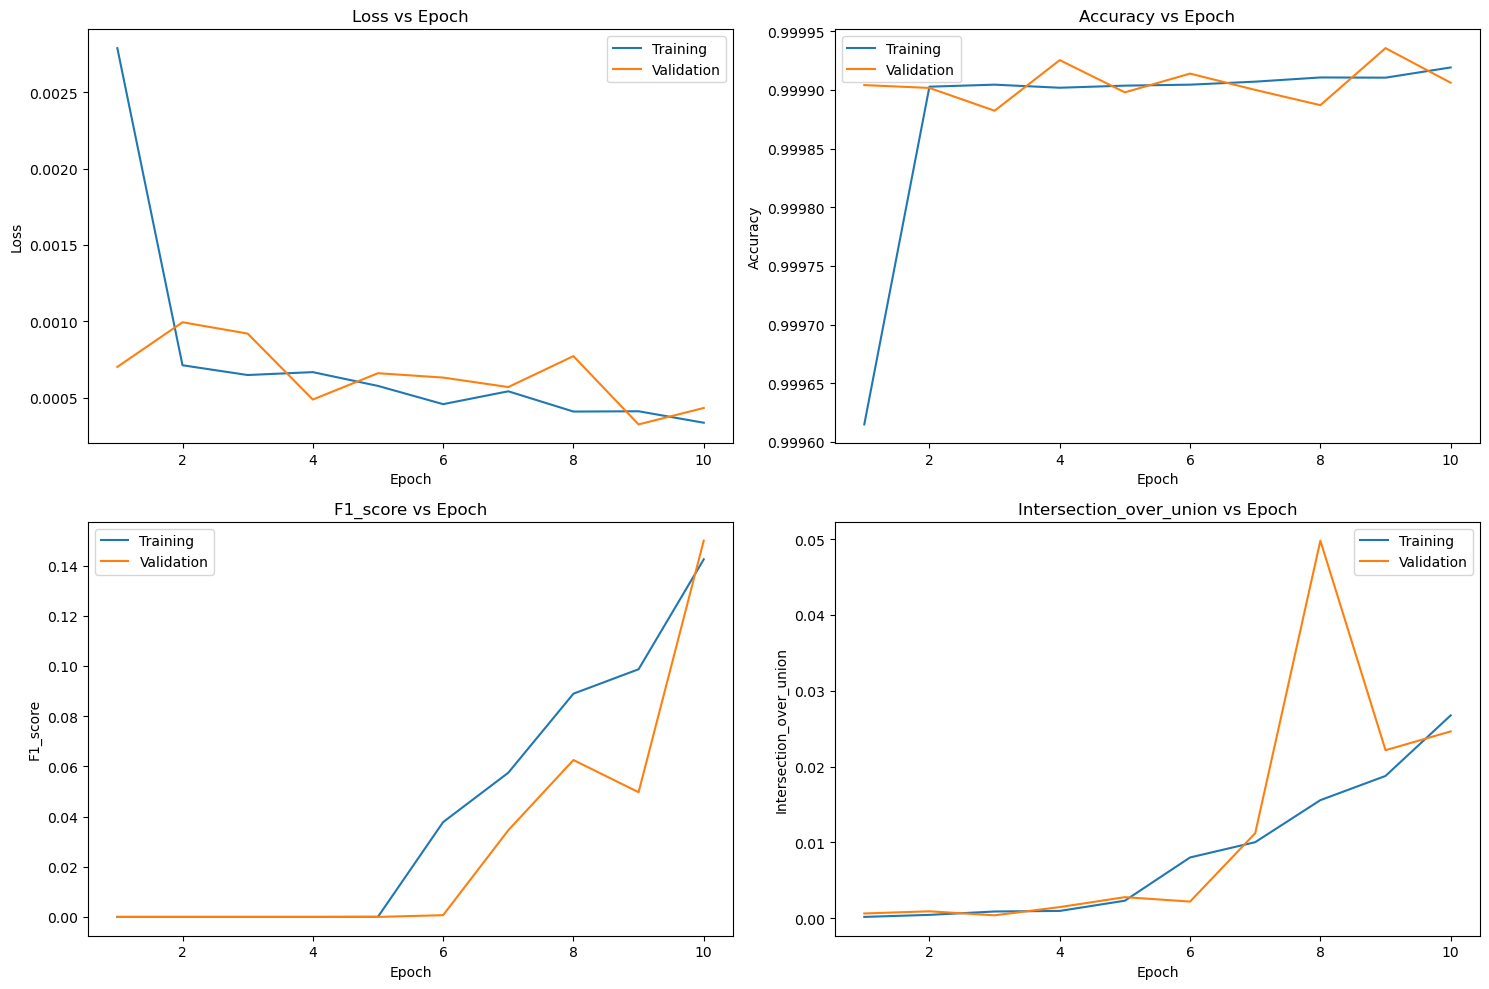

In [29]:
# Plot the training metrics
plot_metrics(history_seed)

1/1 [==============================] - 0s 22ms/step


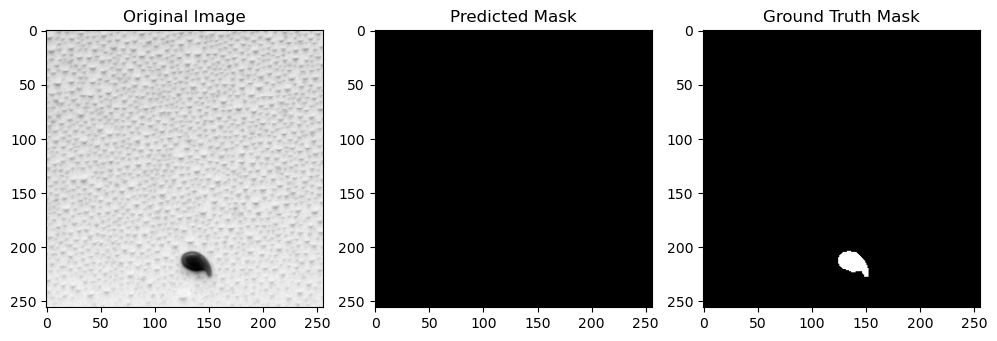

In [70]:
# Assuming 'val_gen' contains test images and masks
num_images_to_load = 16  
loaded_images = []
loaded_masks = []

for _ in range(num_images_to_load):
    batch = next(val_gen)
    loaded_images.extend(batch[0])  
    loaded_masks.extend(batch[1])   

# Selecting the specific image and mask for visualization
selected_image_index = 5  # Choose the index of the image you want to visualize
selected_image = loaded_images[selected_image_index]
selected_mask = loaded_masks[selected_image_index]

# Assuming predicted_masks.shape = (num_images, height, width, channels)
predicted_masks = model_seed.predict(np.expand_dims(selected_image, axis=0))
prediction = np.argmax(predicted_masks[0], axis=-1)  

# Visualize the selected image, predicted mask, and ground truth mask (if available)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
ax[0].imshow(selected_image.squeeze(), cmap='gray')  

# Display the predicted mask
ax[1].imshow(prediction.squeeze(), cmap='gray')  

# Display the ground truth mask if available
ax[2].imshow(selected_mask.squeeze(), cmap='gray')  

# Set titles
ax[0].set_title('Original Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [63]:
# Save the trained model
model_seed.save('./model_seed.h5')

c:\Users\neilr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
# Save model architecture as JSON
model_json = model_seed.to_json()
with open('./model_seed_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model_seed.save_weights('./model_seed_weights.h5')

---
**Model that predicts occluded root**

In [30]:
def create_data_generators_for_occ_root(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'occluded_root/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=16,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images

In [31]:
# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256  # Assuming patch_size is predefined

# Create generators for each dataset category
train_gen, train_num_images = create_data_generators_for_occ_root('train', img_patches_path, mask_patches_path, patch_size)
test_gen, test_num_images = create_data_generators_for_occ_root('test', img_patches_path, mask_patches_path, patch_size)
val_gen, val_num_images = create_data_generators_for_occ_root('val', img_patches_path, mask_patches_path, patch_size)

# Print the number of images in each category
print(f"Train images: {train_num_images}")
print(f"Test images: {test_num_images}")
print(f"Val images: {val_num_images}")

Found 8712 images belonging to 1 classes.
Found 8712 images belonging to 1 classes.
8712
Found 4014 images belonging to 1 classes.
Found 3267 images belonging to 1 classes.
4014
Found 1936 images belonging to 1 classes.
Found 1936 images belonging to 1 classes.
1936
Train images: 8712
Test images: 4014
Val images: 1936


In [32]:
model_occ_root = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True,
                   mode='min')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 256, 256, 16)         160       ['input_5[0][0]']             
                                                                                                  
 dropout_36 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_76[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_36[0][0]']          
                                                                                            

In [33]:
# Training configuration
batch_size = 16
epochs = 10

# Calculate steps per epoch for training and validation
train_steps_per_epoch = train_num_images // batch_size
val_steps_per_epoch = val_num_images // batch_size

# Start training the model
history_occ_root = model_occ_root.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    callbacks=[cb],
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
544/544 [==============================] - 683s 1s/step - loss: 0.0057 - accuracy: 0.9967 - f1_score: 4.3414e-07 - intersection_over_union: 2.3880e-04 - val_loss: 0.0020 - val_accuracy: 0.9997 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 2.5333e-04
Epoch 2/10
544/544 [==============================] - 732s 1s/step - loss: 4.3382e-04 - accuracy: 1.0000 - f1_score: 0.0000e+00 - intersection_over_union: 0.0016 - val_loss: 0.0020 - val_accuracy: 0.9997 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 1.7429e-04
Epoch 3/10
544/544 [==============================] - 736s 1s/step - loss: 3.9327e-04 - accuracy: 1.0000 - f1_score: 0.0000e+00 - intersection_over_union: 0.0063 - val_loss: 0.0020 - val_accuracy: 0.9997 - val_f1_score: 0.0000e+00 - val_intersection_over_union: 0.0011
Epoch 4/10
544/544 [==============================] - 729s 1s/step - loss: 3.9871e-04 - accuracy: 1.0000 - f1_score: 0.0000e+00 - intersection_over_union: 0.0024 - val_loss: 0.0021 - va

In [14]:
# Predict masks for test data
predicted_root_masks = model_occ_root.predict(val_gen, steps=test_num_images // batch_size)

250/250 [==============================] - 59s 237ms/step


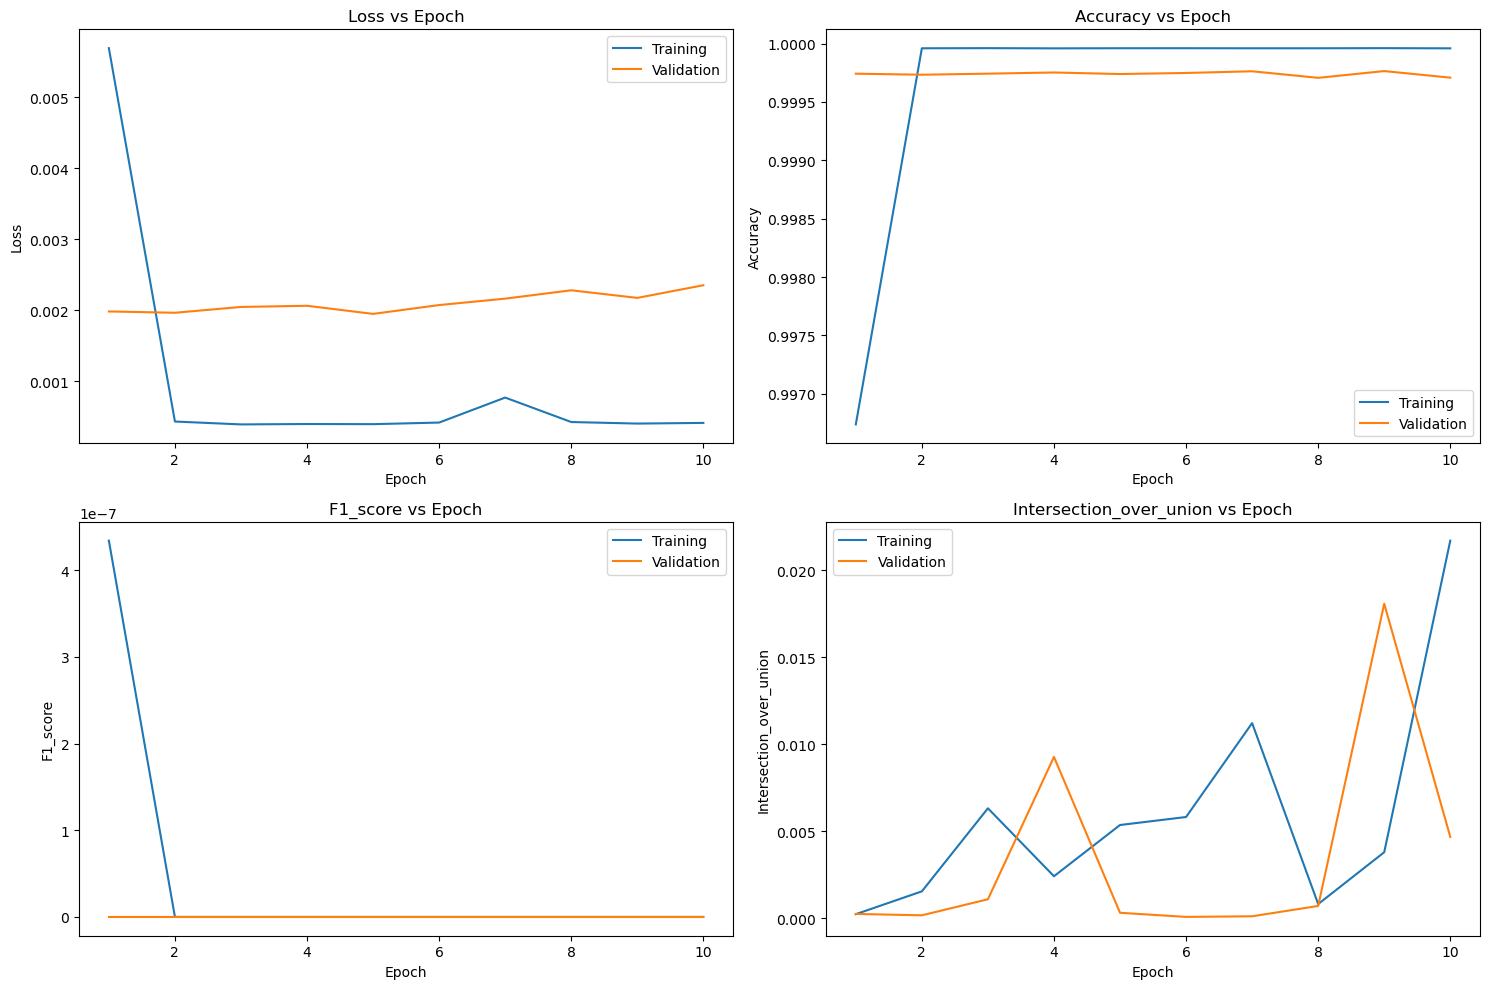

In [34]:
# Plot the training metrics
plot_metrics(history_occ_root)

1/1 [==============================] - 0s 30ms/step


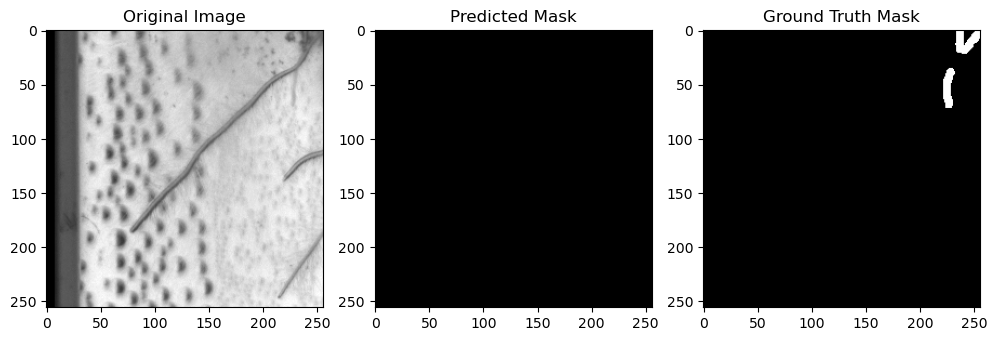

In [27]:
# Assuming 'val_gen' contains test images and masks
num_images_to_load = 20  
loaded_images = []
loaded_masks = []

for _ in range(num_images_to_load):
    batch = next(val_gen)
    loaded_images.extend(batch[0])  
    loaded_masks.extend(batch[1])   

# Selecting the specific image and mask for visualization
selected_image_index = 0  # Choose the index of the image you want to visualize
selected_image = loaded_images[selected_image_index]
selected_mask = loaded_masks[selected_image_index]

# Assuming predicted_masks.shape = (num_images, height, width, channels)
predicted_masks = model_occ_root.predict(np.expand_dims(selected_image, axis=0))
prediction = np.argmax(predicted_masks[0], axis=-1)  

# Visualize the selected image, predicted mask, and ground truth mask (if available)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the original image
ax[0].imshow(selected_image.squeeze(), cmap='gray')  

# Display the predicted mask
ax[1].imshow(prediction.squeeze(), cmap='gray')  

# Display the ground truth mask if available
ax[2].imshow(selected_mask.squeeze(), cmap='gray')  

# Set titles
ax[0].set_title('Original Image')
ax[1].set_title('Predicted Mask')
ax[2].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [28]:
# Save the trained model
model_occ_root.save('./model_occ_root.h5')

c:\Users\neilr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# Save model architecture as JSON
model_json = model_occ_root.to_json()
with open('./model_occ_root_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model_occ_root.save_weights('./model_occ_root_weights.h5')

---
# Thresholding the predictions of the root_model to improve iou

In [22]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)


In [23]:
from keras.models import load_model
# Load the saved model by providing custom metrics as custom_objects
model_root = load_model('../Task 4/model_root.h5', custom_objects={'f1_score': f1, 'intersection_over_union': iou})

In [11]:
def create_data_generators_for_root(category, img_patches_path, mask_patches_path, patch_size):
    # Data generator for images
    img_data_gen = ImageDataGenerator(rescale=1./255)

    img_gen = img_data_gen.flow_from_directory(
        directory=os.path.join(img_patches_path, category),
        target_size=(patch_size, patch_size),
        batch_size=8,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',  # Ensure consistent color mode
        seed=42)

    # Data generator for masks
    mask_data_gen = ImageDataGenerator()

    mask_gen = mask_data_gen.flow_from_directory(
        directory=os.path.join(mask_patches_path, f'root/{category}'),
        target_size=(patch_size, patch_size),
        batch_size=8,
        class_mode=None,  # No labels for val and test data
        color_mode='grayscale',  # Ensure consistent color mode
        seed=42)

    # Combine the image and mask generators
    combined_gen = zip(img_gen, mask_gen)

    # Number of images in the dataset category
    num_images = img_gen.samples
    print(num_images)

    return combined_gen, num_images, img_gen, mask_gen

In [14]:
# Paths for image and mask directories
img_patches_path = "./dataset_patched/Images/"
mask_patches_path = "./dataset_patched/Masks/"
patch_size = 256

# Create data generators
combined_gen, num_images, img_gen, mask_gen = create_data_generators_for_root('test', img_patches_path, mask_patches_path, patch_size)

# Reset the generators
img_gen.reset()
mask_gen.reset()

y_true = []
y_pred = []

Found 4014 images belonging to 1 classes.
Found 4014 images belonging to 1 classes.
4014


In [15]:
for i in range(len(img_gen)):
    batch_images = next(img_gen)
    batch_masks_true = next(mask_gen)

    y_true.append(batch_masks_true)

    batch_masks_pred = model_root.predict(batch_images)

    y_pred.append(batch_masks_pred)

1/1 [==============================] - 0s 156ms/step


In [17]:
y_true[0].shape

(8, 256, 256, 1)

In [ ]:
y_pred.shape

(263061504, 1)

In [18]:
# Convert list to array
x_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

In [19]:
x_true.shape

(4014, 256, 256, 1)

In [20]:
y_pred.shape

(4014, 256, 256, 1)

In [24]:
# Apply threshold to model predictions
y_pred_thresholded = y_pred > 0.5

# Calculate IoU using your custom iou function
iou_score = iou(K.variable(x_true), K.variable(y_pred_thresholded))

print("test_iou:", K.eval(iou_score))

test_iou: 0.6469466
